## Module 2 Project 

link to spreadsheet: https://docs.google.com/spreadsheets/d/1kL1rU6_G7Klr78RxtadjEI4dSzmYr3hZEPXT-HaghnA/edit#gid=453759461

link to github: https://github.com/petehumphries/Flatiron_School-Module_2_Proj.git


### Executive Summary

This notebook is split into the following sections:

    1) Connect to the SQL database
    2) Extract + Transform + Load
    3) 


Upon completion of this lab, each unique team in this dataset should have a record in the MongoDB instance containing the following information:

The name of the team
The total number of goals scored by the team during the 2011 season
The total number of wins the team earned during the 2011 season
A histogram visualization of the team's wins and losses for the 2011 season (store the visualization directly)

The team's win percentage on days where it was raining during games in the 2011 season.

### Inputs

    All team names
    All Match results for 2011
    All goals scored for 2011
    All match dates 
    
    Weather

SQL DB: Name of team, goals scored during the 2011 season, total number of wins
Weather: From the Weather API - Berlin only
Join by date

List the match days => max = 365, likely below 200

### Tables:

There are the following Tables: 

Matches, Teams, Unique Teams, Teams_in_Matches, FlatView, FlatView_Advanced, FlatView_Chrono_TeamOrder_Reduced,  

Match_ID (int): unique ID per match
Div (str): identifies the division the match was played in (D1 = Bundesliga, D2 = Bundesliga 2, E0 = English Premier League)
Season (int): Season the match took place in (usually covering the period of August till May of the following year)
Date (str): Date of the match
HomeTeam (str): Name of the home team
AwayTeam (str): Name of the away team
FTHG (int) (Full Time Home Goals): Number of goals scored by the home team
FTAG (int) (Full Time Away Goals): Number of goals scored by the away team
FTR (str) (Full Time Result): 3-way result of the match (H = Home Win, D = Draw, A = Away Win)

#### Table: Teams

Season (str): Football season for which the data is valid
TeamName (str): Name of the team the data concerns
KaderHome (str): Number of Players in the squad
AvgAgeHome (str): Average age of players
ForeignPlayersHome (str): Number of foreign players (non-German, non-English respectively) playing for the team
OverallMarketValueHome (str): Overall market value of the team pre-season in EUR (based on data from transfermarkt.de)
AvgMarketValueHome (str): Average market value (per player) of the team pre-season in EUR (based on data from transfermarkt.de)
StadiumCapacity (str): Maximum stadium capacity of the team's home stadium

#### Table: Unique Teams

TeamName (str): Name of a team
Unique_Team_ID (int): Unique identifier for each team

#### Table: Teams_in_Matches

Match_ID (int): Unique match ID
Unique_Team_ID (int): Unique team ID (This table is used to easily retrieve each match a given team has played in)
Based on these tables I created a couple of views which I used as input for my machine learning models:

#### View: FlatView

Combination of all matches with the respective additional data from Teams table for both home and away team.

#### View: FlatView_Advanced

Same as Flatview but also includes Unique_Team_ID and Unique_Team in order to easily retrieve all matches played by a team in chronological order.

#### View: FlatView_Chrono_TeamOrder_Reduced

Similar to Flatview_Advanced, however missing the additional attributes from team in order to have a longer history including years 1993 - 2004. Especially interesting if one is only interested in analyzing winning/loosing streaks.
Match_ID (int): unique ID per match
Div (str): identifies the division the match was played in (D1 = Bundesliga, D2 = Bundesliga 2, E0 = English Premier League)
Season (int): Season the match took place in (usually covering the period of August till May of the following year)
Date (str): Date of the match
HomeTeam (str): Name of the home team
AwayTeam (str): Name of the away team
FTHG (int) (Full Time Home Goals): Number of goals scored by the home team
FTAG (int) (Full Time Away Goals): Number of goals scored by the away team
FTR (str) (Full Time Result): 3-way result of the match (H = Home Win, D = Draw, A = Away Win)

In [316]:
import sqlite3
import pandas as pd
import numpy as np
import json

conn = sqlite3.connect('database.sqlite')
cur = conn.cursor()

Extracting all games from the Matches table, filtering on the 2011 season

Excluding the Enplish Premiership Games from the import using AND Div <> 'E0' condition. 612 entries

In [317]:
cur.execute("""SELECT * FROM MATCHES WHERE Season == '2011' AND Div <> 'E0';""")

In [318]:
len(cur.fetchall()) # 612 rows expected

612

To exclude the English Premier League Matches where Div = E0

In [319]:
cur.execute("""SELECT * FROM MATCHES WHERE Season == '2011' AND Div <> 'E0';""")
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head(1000)

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D
...,...,...,...,...,...,...,...,...,...
607,1699,D2,2011,2011-07-24,Paderborn,Fortuna Dusseldorf,1,1,D
608,1700,D2,2011,2011-12-10,Bochum,Fortuna Dusseldorf,1,1,D
609,1701,D2,2011,2011-08-15,Ein Frankfurt,Fortuna Dusseldorf,1,1,D
610,1702,D2,2011,2011-08-27,Aachen,Fortuna Dusseldorf,0,0,D


Creating a new column to show "Match_Winner" 

In [320]:
col         = 'FTR'
conditions  = [ df[col] == 'H', df[col] == 'A', df[col] == 'D' ]
choices     = [ df['HomeTeam'], df['AwayTeam'], 'Draw' ]
df["Match_Winner"] = np.select(conditions, choices, default=np.nan) 

col         = 'FTR'
conditions  = [ df[col] == 'H', df[col] == 'A', df[col] == 'D' ]
choices     = [ df['AwayTeam'], df['HomeTeam'], 'Draw' ]

df["Match_Loser"] = np.select(conditions, choices, default=np.nan) 

In [321]:
df

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Match_Winner,Match_Loser
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A,Bayern Munich,Nurnberg
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A,Bayern Munich,Stuttgart
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A,Bayern Munich,Wolfsburg
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H,Mainz,Bayern Munich
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D,Draw,Draw
...,...,...,...,...,...,...,...,...,...,...,...
607,1699,D2,2011,2011-07-24,Paderborn,Fortuna Dusseldorf,1,1,D,Draw,Draw
608,1700,D2,2011,2011-12-10,Bochum,Fortuna Dusseldorf,1,1,D,Draw,Draw
609,1701,D2,2011,2011-08-15,Ein Frankfurt,Fortuna Dusseldorf,1,1,D,Draw,Draw
610,1702,D2,2011,2011-08-27,Aachen,Fortuna Dusseldorf,0,0,D,Draw,Draw


In [322]:
match_dates_unique=df['Date'].unique()
len(match_dates_unique)

136

Selecting the unique dates of football matches to send weather requestes for. Want to minimise the requests

In [323]:
match_dates = np.sort(match_dates_unique)
match_dates

array(['2011-07-15', '2011-07-16', '2011-07-17', '2011-07-18',
       '2011-07-22', '2011-07-23', '2011-07-24', '2011-07-25',
       '2011-08-05', '2011-08-06', '2011-08-07', '2011-08-08',
       '2011-08-12', '2011-08-13', '2011-08-14', '2011-08-15',
       '2011-08-19', '2011-08-20', '2011-08-21', '2011-08-22',
       '2011-08-26', '2011-08-27', '2011-08-28', '2011-08-29',
       '2011-09-09', '2011-09-10', '2011-09-11', '2011-09-12',
       '2011-09-16', '2011-09-17', '2011-09-18', '2011-09-19',
       '2011-09-23', '2011-09-24', '2011-09-25', '2011-09-26',
       '2011-09-30', '2011-10-01', '2011-10-02', '2011-10-03',
       '2011-10-14', '2011-10-15', '2011-10-16', '2011-10-17',
       '2011-10-21', '2011-10-22', '2011-10-23', '2011-10-28',
       '2011-10-29', '2011-10-30', '2011-10-31', '2011-11-04',
       '2011-11-05', '2011-11-06', '2011-11-07', '2011-11-18',
       '2011-11-19', '2011-11-20', '2011-11-21', '2011-11-25',
       '2011-11-26', '2011-11-27', '2011-11-28', '2011-

Build a function to turn match days in to an array

In [9]:
def weather_required_dates(match_dates):
    weather_req_dates = []
    for d in match_dates:
        weather_req_dates.append(d)
    return weather_req_dates

In [53]:
match_days = weather_required_dates(match_dates)
df_match_days=pd.DataFrame(match_days)
df_match_days.columns = ['Date']
df_match_days.head(2)

,Date
0,2011-07-15
1,2011-07-16


### Dark Skies API

Data requirement from Dark Skies AP

Finally, let's get our client id and API key into our jupyter notebook.
If we remember that our file is just a regular JSON file, open the file and pull out the appropriate information from the ~/.secret/yelp_api.json file.

The API documentation can be found at: https://darksky.net/dev/docs

The Co-ordinates for Berlin sourced from https://latitude.to/map/de/germany/cities/berlin are:

DD 52.52437 13.41053

DMS 52°31'27.73" N 13°24'37.91" E

In [11]:
import json

#path = "~/.secret/dark_sky_api.txt"
path = 'c://Users/User1/.secret/dark_sky_api.txt'

def get_keys(path):
    with open(path) as f:
        return json.load(f)

In [12]:
keys = get_keys(path)
#print(keys)

In [13]:
api_key = keys['api_key']

The API documentation can be found at: https://darksky.net/dev/docs

In [14]:
latitude = 52.52437 
longitude = 13.41053

import requests
SEARCH_LIMIT = 1
url = 'https://api.darksky.net/forecast/'+api_key+'/'+ str(latitude) +','+ str(longitude)
response = requests.get(url)

First test response from the API using the "currently" default and longitude & latitude

In [15]:
#https://api.darksky.net/forecast/[api_key]/[latitude],[longitude]
print(response)
print(type(response.text))
print(response.text[:500])

<Response [200]>
<class 'str'>
{"latitude":52.52437,"longitude":13.41053,"timezone":"Europe/Berlin","currently":{"time":1580459091,"summary":"Overcast","icon":"cloudy","precipIntensity":0.0022,"precipProbability":0.17,"precipType":"rain","temperature":47.92,"apparentTemperature":41.65,"dewPoint":44.21,"humidity":0.87,"pressure":1002.7,"windSpeed":16.36,"windGust":32.92,"windBearing":277,"cloudCover":0.93,"uvIndex":0,"visibility":10,"ozone":286},"hourly":{"summary":"Light rain starting tomorrow morning.","icon":"rain","data":[


### Time Machine Request

We need to return one weather request per match date. DarkSky uses the unix date convention, so match dates need to be converted in UNIX DATE FORMAT. Running with a test date

In [16]:
date = '2011-07-17'
url = 'https://api.darksky.net/forecast/'+api_key+'/'+ str(latitude) +','+ str(longitude) + ',' +str(date) + 'T16:00:00'
url

'https://api.darksky.net/forecast/cc668e0d95b3fa324b37c548fe2b5731/52.52437,13.41053,2011-07-17T16:00:00'

In [54]:
test_response = requests.get(url)
print(test_response)
print(type(test_response.text))
print(test_response.text[:500])

<Response [200]>
<class 'str'>
{"latitude":52.52437,"longitude":13.41053,"timezone":"Europe/Berlin","currently":{"time":1310911200,"precipIntensity":0,"precipProbability":0,"temperature":79.39,"apparentTemperature":79.39,"dewPoint":55.79,"humidity":0.44,"windSpeed":14.96,"windGust":14.99,"windBearing":230,"visibility":6.206},"hourly":{"summary":"Rain overnight and in the evening.","icon":"rain","data":[{"time":1310853600,"precipIntensity":0,"precipProbability":0,"temperature":65.79,"apparentTemperature":65.79,"dewPoint":50.83


### Create a Weather Class: OOP Requirement 1

In [42]:
class WeatherGetter():
# The function works is slim and only runs once 

    def __init__(self):    

        self.latitude = 52.52437 
        self.longitude = 13.41053
        
    def weather_retriever(self, match_days):
        weather = []
        for date in match_days:
            url = 'https://api.darksky.net/forecast/'+api_key+'/'+ str(self.latitude) +','+ str(self.longitude) + ',' +str(date) + 'T16:00:00'
            response = requests.get(url)
            weather.append(response.json()['daily']['data'][0].get('icon','clear'))
        return(weather)

Test the Class on a single date before sending all match dates to the API 

In [55]:
test_single_run = weather_testing.weather_retriever(['2011-07-15'])

In [56]:
test_single_run

['partly-cloudy-day']

In [50]:
weather = weather_testing.weather_retriever(match_days)

In [51]:
len(weather)

136

In [19]:
weather

Save the weather output down as an emergency fallback in case of API issues later!!!!!!!!!!

In [61]:
df_weather=pd.DataFrame(weather)
df_weather.to_csv('weather_on_match_days_berlin')

Add weather to df_match_ days vector to build a match day vs weather dictionary / key value / pair 

In [22]:
df_match_days['Weather'] = weather

In [23]:
#df_match_days.columns = ['Date']#, 'Weather']
df_match_days

,Date,Weather
0,2011-07-15,partly-cloudy-day
1,2011-07-16,clear
2,2011-07-17,rain
3,2011-07-18,rain
4,2011-07-22,rain
...,...,...
131,2012-04-23,clear
132,2012-04-28,clear
133,2012-04-29,clear
134,2012-05-05,rain


Join / Merge the weather information to the results dataframe 

In [324]:
df = pd.merge(df,df_match_days)

In [325]:
df

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Match_Winner,Match_Loser
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A,Bayern Munich,Nurnberg
1,1189,D1,2011,2012-03-31,Augsburg,FC Koln,2,1,H,Augsburg,FC Koln
2,1206,D1,2011,2012-03-31,Leverkusen,Freiburg,0,2,A,Freiburg,Leverkusen
3,1215,D1,2011,2012-03-31,Kaiserslautern,Hamburg,0,1,A,Hamburg,Kaiserslautern
4,1396,D2,2011,2012-03-31,Munich 1860,Hansa Rostock,0,1,A,Hansa Rostock,Munich 1860
...,...,...,...,...,...,...,...,...,...,...,...
607,1689,D2,2011,2011-12-05,Duisburg,Fortuna Dusseldorf,0,2,A,Fortuna Dusseldorf,Duisburg
608,1690,D2,2011,2012-04-16,Dresden,Fortuna Dusseldorf,2,1,H,Dresden,Fortuna Dusseldorf
609,1694,D2,2011,2011-10-03,Braunschweig,Fortuna Dusseldorf,1,1,D,Draw,Draw
610,1696,D2,2011,2012-03-19,Cottbus,Fortuna Dusseldorf,1,1,D,Draw,Draw


In [330]:
season_wins = df.groupby(['Match_Winner'])['Match_ID'].count()

season_wins = pd.DataFrame(season_wins)
season_wins = season_wins.reset_index()
season_wins.columns = ['Team', 'SeasonWins']
delete_row = season_wins[season_wins["Team"]=="Draw"].index
season_wins = season_wins.drop(delete_row)
season_wins.head(38)


season_losses = df.groupby(['Match_Loser'])['Match_ID'].count()

season_losses = pd.DataFrame(season_losses)
season_losses = season_losses.reset_index()
season_losses.columns = ['Team', 'SeasonLosses']
delete_row = season_losses[season_losses["Team"]=="Draw"].index
season_losses = season_losses.drop(delete_row)
season_losses.head(38)

seasons_results = pd.merge(season_wins, season_losses)

# season_losses = df.groupby(['Match_Loser'])['Match_ID'].count()

seasons_results['Draws'] = 34 - seasons_results['SeasonWins'] - seasons_results['SeasonLosses']
seasons_results

# season_losses

,Team,SeasonWins,SeasonLosses,Draws
0,Aachen,6,15,13
1,Augsburg,8,12,14
2,Bayern Munich,23,7,4
3,Bochum,10,17,7
4,Braunschweig,10,9,15
5,Cottbus,8,15,11
6,Dortmund,25,3,6
7,Dresden,12,13,9
8,Duisburg,10,15,9
9,Ein Frankfurt,20,6,8


Save the dataframe to csv in case of need to rollback

In [277]:
df.to_csv('win_lose_draw_rain.csv')

In [278]:
home = df['HomeTeam'].unique()
away = df['AwayTeam'].unique()
len(home) == len(away)

True

Start the process of creating team name, wins, losses, percentage, rain wins percentage

In [279]:
home_goals_sum = df['FTHG'].sum() # 996 home goals
print('home goals: total for 2011 = ' + str(home_goals_sum))
away_goals_sum = df['FTAG'].sum() # 734 away goals
print('away goals: total for 2011 = ' + str(away_goals_sum))

home goals: total for 2011 = 996
away goals: total for 2011 = 734


In [280]:
len(df['Match_ID'].unique()) # 612 unique match ids

612

Creat Group By Summary Stats for the Output table

In [281]:
home_goals = df.groupby(['HomeTeam'])['FTHG'].sum()
home_goals=pd.DataFrame(home_goals)
home_goals = home_goals.reset_index()
home_goals.columns = ['Team', 'FTHG']

away_goals = df.groupby(['AwayTeam'])['FTAG'].sum()
away_goals=pd.DataFrame(away_goals)
away_goals = away_goals.reset_index()
away_goals.columns = ['Team', 'FTAG']

In [282]:
rainy_games = df.loc[(df['Weather'] == 'rain')]
rainy_games.head()

rainy_home_games = rainy_games.groupby(['HomeTeam'])['Match_ID'].count()
rainy_home_games = pd.DataFrame(rainy_home_games)
rainy_home_games = rainy_home_games.reset_index()
rainy_home_games.columns = ['Team', 'Rainy_Home_Games']
rainy_home_games.head(2)

rainy_away_games = rainy_games.groupby(['AwayTeam'])['Match_ID'].count()
rainy_away_games = pd.DataFrame(rainy_away_games)
rainy_away_games = rainy_away_games.reset_index()
rainy_away_games.columns = ['Team', 'Rainy_Away_Games']
rainy_away_games.head(2)

rainy_wins = rainy_games.groupby(['Match_Winner'])['Match_ID'].count()
rainy_wins = pd.DataFrame(rainy_wins)
rainy_wins = rainy_wins.reset_index()
rainy_wins.columns = ['Team', 'Rainy_Wins']
rainy_wins.head()




,Team,Rainy_Wins
0,Aachen,2
1,Augsburg,3
2,Bayern Munich,5
3,Bochum,2
4,Braunschweig,4


In [283]:
rainy_home_games.head(2)

,Team,Rainy_Home_Games
0,Aachen,2
1,Augsburg,4


In [284]:
rainy_away_games.head(2)

,Team,Rainy_Away_Games
0,Aachen,5
1,Augsburg,2


In [285]:
rainy_games = pd.merge(rainy_home_games, rainy_away_games)
rainy_games

,Team,Rainy_Home_Games,Rainy_Away_Games
0,Aachen,2,5
1,Augsburg,4,2
2,Bayern Munich,3,4
3,Bochum,3,5
4,Braunschweig,4,2
5,Cottbus,3,3
6,Dortmund,3,4
7,Dresden,3,4
8,Duisburg,3,6
9,Ein Frankfurt,3,3


In [286]:
rainy_games['RainyGames'] = rainy_games['Rainy_Home_Games'] + rainy_games['Rainy_Away_Games']
rainy_games.drop(['Rainy_Home_Games', 'Rainy_Away_Games'], axis=1, inplace=True)

In [287]:
rainy_games.head()

,Team,RainyGames
0,Aachen,7
1,Augsburg,6
2,Bayern Munich,7
3,Bochum,8
4,Braunschweig,6


In [288]:
rainy_wins.head(1)

,Team,Rainy_Wins
0,Aachen,2


In [289]:
#rainy_games = pd.merge(rainy_games, rainy_wins)

rainy_games = rainy_games.merge(rainy_wins, on='Team', how='outer')
#left.merge(right, on='key', how='outer')

In [290]:
rainy_games

,Team,RainyGames,Rainy_Wins
0,Aachen,7.0,2.0
1,Augsburg,6.0,3.0
2,Bayern Munich,7.0,5.0
3,Bochum,8.0,2.0
4,Braunschweig,6.0,4.0
5,Cottbus,6.0,2.0
6,Dortmund,7.0,5.0
7,Dresden,7.0,3.0
8,Duisburg,9.0,1.0
9,Ein Frankfurt,6.0,2.0


In [291]:
delete_row = rainy_games[rainy_games["Team"]=="Draw"].index
rainy_games = rainy_games.drop(delete_row)

In [331]:
rainy_games.fillna(0, inplace=True)
#rainy_games

In [339]:
rainy_games['RainyWinsPercentage'] = round(100 * (rainy_games['Rainy_Wins'] / rainy_games['RainyGames']),2)
#rainy_games

In [340]:
away_goals.head(2)

,Team,FTAG
0,Aachen,15
1,Augsburg,16


In [341]:
home_goals.head(2)

,Team,FTHG
0,Aachen,15
1,Augsburg,20


In [342]:
total_goals = pd.merge(home_goals, away_goals)

Create a total goals column:

In [343]:
total_goals['FTTG'] = total_goals['FTHG'] + total_goals['FTAG']
total_goals.head(36)
total_goals = pd.merge(total_goals, seasons_results)

In [344]:
total_goals = pd.merge(total_goals, away_goals)

In [345]:
total_goals = pd.merge(total_goals, rainy_games)

In [347]:
total_goals

,Team,FTHG,FTAG,FTTG,SeasonWins,SeasonLosses,Draws,RainyGames,Rainy_Wins,Percentage,RainyWinsPercentage
0,Aachen,15,15,30,6,15,13,7.0,2.0,28.57,28.57
1,Augsburg,20,16,36,8,12,14,6.0,3.0,50.00,50.00
2,Bayern Munich,49,28,77,23,7,4,7.0,5.0,71.43,71.43
3,Bochum,23,18,41,10,17,7,8.0,2.0,25.00,25.00
4,Braunschweig,21,16,37,10,9,15,6.0,4.0,66.67,66.67
5,Cottbus,18,12,30,8,15,11,6.0,2.0,33.33,33.33
6,Dortmund,44,36,80,25,3,6,7.0,5.0,71.43,71.43
7,Dresden,30,20,50,12,13,9,7.0,3.0,42.86,42.86
8,Duisburg,23,19,42,10,15,9,9.0,1.0,11.11,11.11
9,Ein Frankfurt,38,38,76,20,6,8,6.0,2.0,33.33,33.33


In [338]:
total_goals.to_csv('final_table.csv')

In [354]:
df_mongo = total_goals.to_dict(orient = 'records')

## Export to Mongo

In [355]:
import pymongo
import requests

In [356]:
df_mongo = total_goals.to_dict(orient = 'records')

In [357]:
df_mongo

[{'Team': 'Aachen',
  'FTHG': 15,
  'FTAG': 15,
  'FTTG': 30,
  'SeasonWins': 6,
  'SeasonLosses': 15,
  'Draws': 13,
  'RainyGames': 7.0,
  'Rainy_Wins': 2.0,
  'Percentage': 28.57,
  'RainyWinsPercentage': 28.57},
 {'Team': 'Augsburg',
  'FTHG': 20,
  'FTAG': 16,
  'FTTG': 36,
  'SeasonWins': 8,
  'SeasonLosses': 12,
  'Draws': 14,
  'RainyGames': 6.0,
  'Rainy_Wins': 3.0,
  'Percentage': 50.0,
  'RainyWinsPercentage': 50.0},
 {'Team': 'Bayern Munich',
  'FTHG': 49,
  'FTAG': 28,
  'FTTG': 77,
  'SeasonWins': 23,
  'SeasonLosses': 7,
  'Draws': 4,
  'RainyGames': 7.0,
  'Rainy_Wins': 5.0,
  'Percentage': 71.43,
  'RainyWinsPercentage': 71.43},
 {'Team': 'Bochum',
  'FTHG': 23,
  'FTAG': 18,
  'FTTG': 41,
  'SeasonWins': 10,
  'SeasonLosses': 17,
  'Draws': 7,
  'RainyGames': 8.0,
  'Rainy_Wins': 2.0,
  'Percentage': 25.0,
  'RainyWinsPercentage': 25.0},
 {'Team': 'Braunschweig',
  'FTHG': 21,
  'FTAG': 16,
  'FTTG': 37,
  'SeasonWins': 10,
  'SeasonLosses': 9,
  'Draws': 15,
  'Rainy

In [358]:
myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017/")

# create a db

phdb = myclient['footie']

myclient.list_database_names()

['admin', 'config', 'example_data', 'local']

In [359]:
mycollection = phdb['Footie']
phdb.list_collection_names()

[]

In [360]:
mycollection.insert_many(df_mongo)

In [361]:
#test query

query = mycollection.find({'Team': 'Bochum'})
for document in query:
    print(document)

{'_id': ObjectId('5e343f7ed1ba96a6a667e121'), 'Team': 'Bochum', 'FTHG': 23, 'FTAG': 18, 'FTTG': 41, 'SeasonWins': 10, 'SeasonLosses': 17, 'Draws': 7, 'RainyGames': 8.0, 'Rainy_Wins': 2.0, 'Percentage': 25.0, 'RainyWinsPercentage': 25.0}


In [364]:
total_goals.iloc[0][4] 

6

In [365]:
total_goals.iloc[0][5] 

15

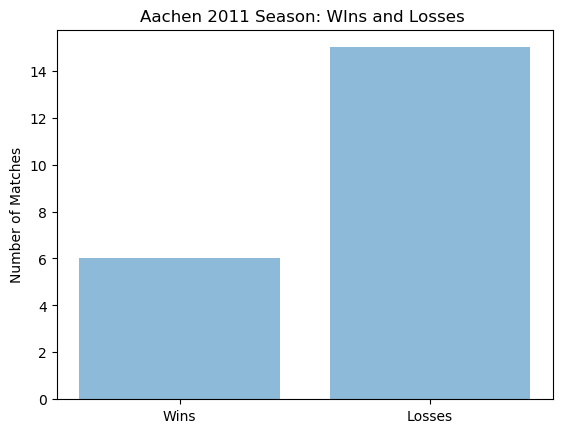

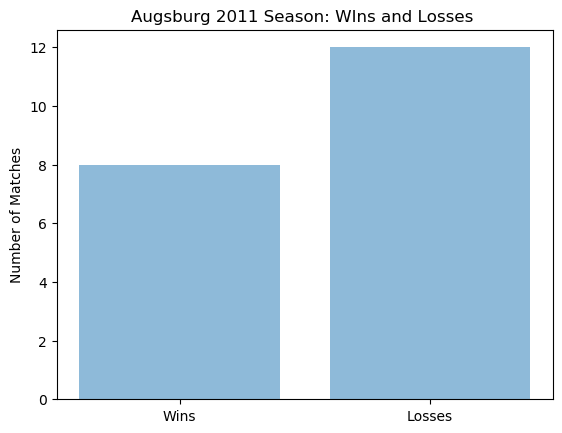

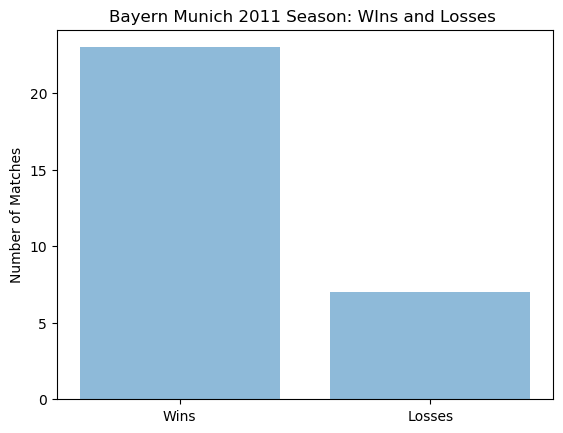

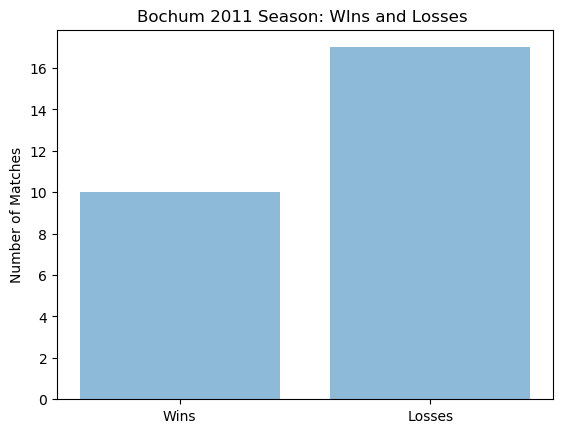

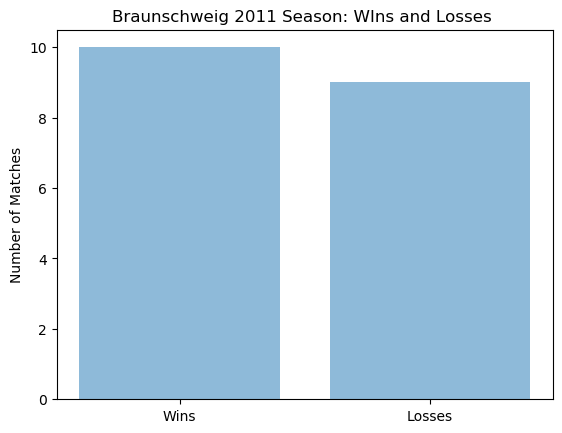

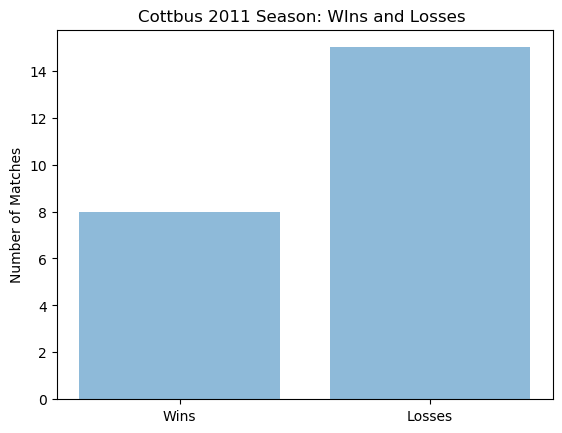

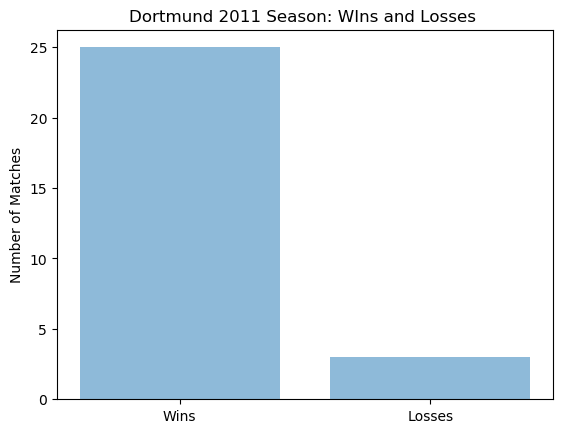

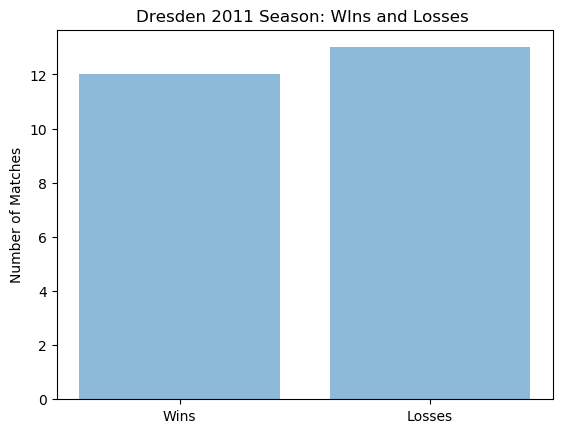

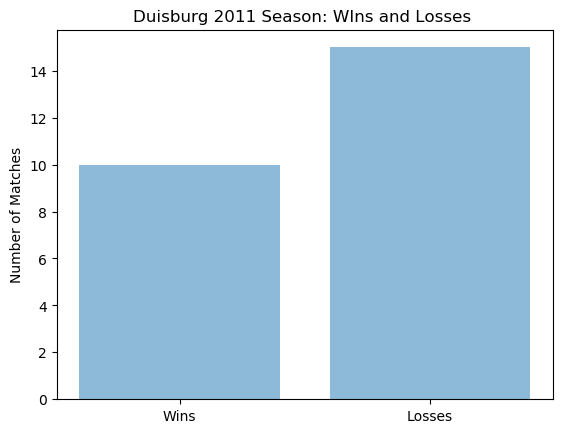

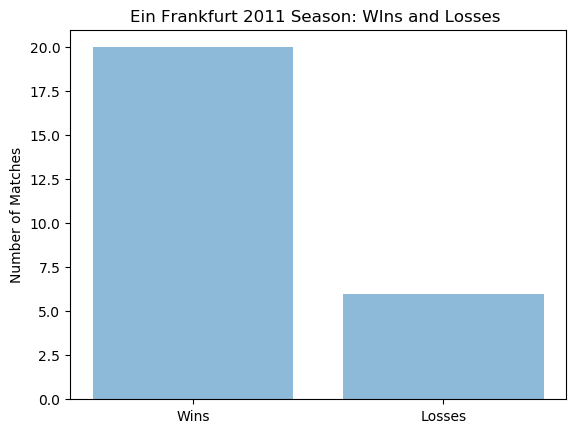

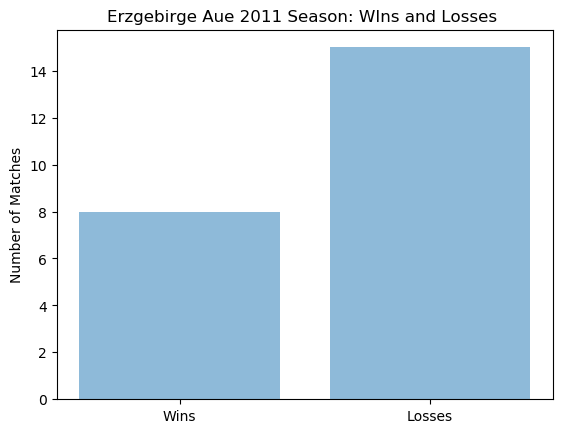

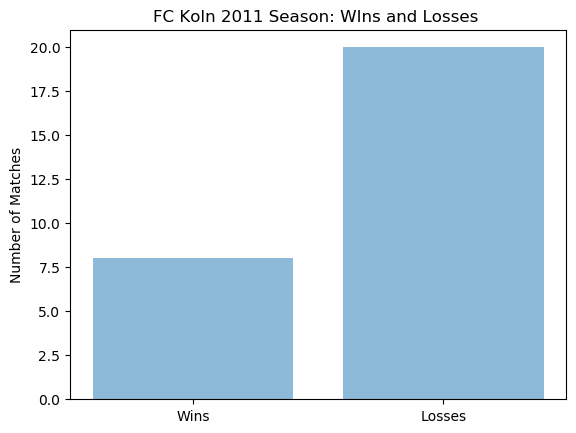

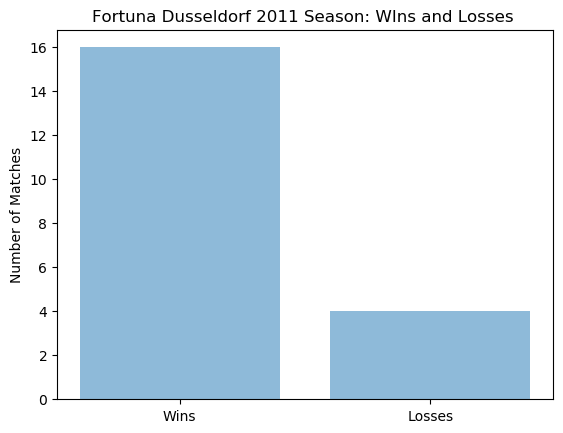

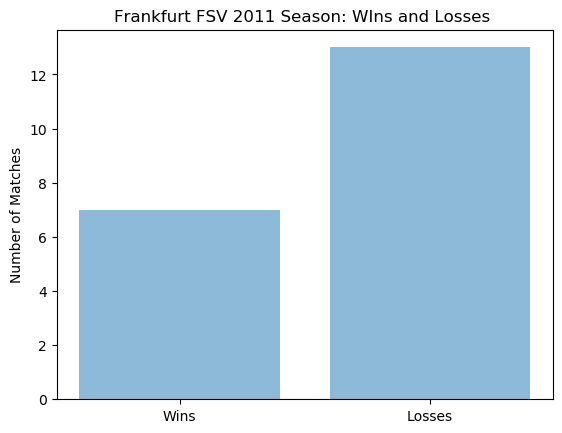

In [ ]:
teams = total_goals['Team']
objects = ('Wins', 'Losses')
i = 0

for team in teams:
    team_name = str(total_goals.iloc[i][0])

 #   y_pos = np.arange(len(objects))
    performance = [int(total_goals.iloc[i][4]), int(total_goals.iloc[i][5])]

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Number of Matches')
    plt.title(team_name + ' 2011 Season: WIns and Losses ')
    plt.show()
    i = i + 1

In [384]:
teams

,Team
0,Aachen
1,Augsburg
2,Bayern Munich
3,Bochum
4,Braunschweig
5,Cottbus
6,Dortmund
7,Dresden
8,Duisburg
9,Ein Frankfurt
